In [1]:
import pandas as pd
import umap
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN

import pickle

from konlpy.tag import Okt

In [2]:
from sentence_transformers import SentenceTransformer, models
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

#word_embedding_model = models.Transformer('monologg/distilkobert')
#pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
#model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

df = pd.read_excel('201203_1815_3M손소독제.xlsx')
df['리뷰'] = df['리뷰'].map(lambda x : str(x))
data = df['리뷰'].values.tolist()

In [132]:
with open('식품.pkl', 'rb') as f:
    df = pickle.load(f)
df['리뷰'] = df['리뷰'].map(lambda x : str(x))
data = df['리뷰'].values.tolist()

okt = Okt()
tag_list = ['Noun','Adjective']
data = [' '.join([m[0] for m in okt.pos(sentence, stem=True) if m[1] in tag_list]) for sentence in data]

In [ ]:
embeddings = model.encode(data, show_progress_bar=True)

In [ ]:
with open('식품_SBert_embedding.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

cluster = DBSCAN(metric='cosine', eps=0.2, min_samples=2).fit_predict(embeddings)

In [106]:
distance = pairwise_distances(embeddings, metric='cosine')
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='precomputed',
                          cluster_selection_method='eom').fit(distance.astype('float64'))

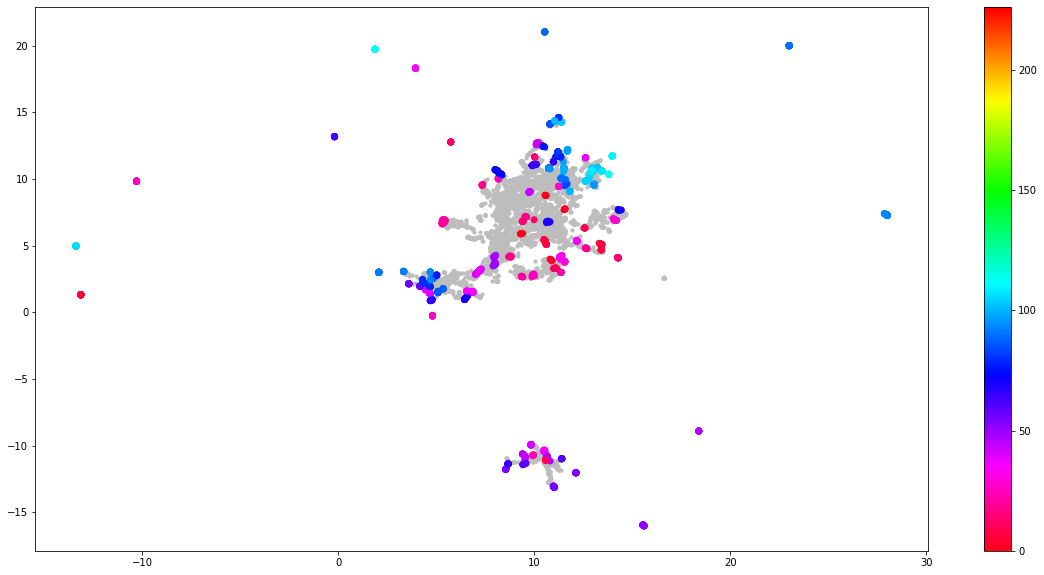

In [107]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, 
                      n_components=2,
                      min_dist=0.0, 
                      metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r', vmax=max(clustered.labels)*2)
plt.colorbar()

In [108]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [109]:
docs_df

,Doc,Topic,Doc_ID
0,손소독제 좋아요,44,0
1,손소독제 좋아요,44,1
2,다른 알코올 손소독제는 닦고나서 손에 잔여물이 남거나 미끈거려서 찝찝하지만 은 역시...,-1,2
3,다른 알코올 손소독제는 닦고나서 손에 잔여물이 남거나 미끈거려서 찝찝하지만 은 역시...,-1,3
4,언제나 믿고 쓰는 제품입니다,-1,4
...,...,...,...
8396,배송도 빠르고 포장도 꼼꼼하게 왔어요 끈적임도 없고 맘에 들어요,-1,8396
8397,파란색은 안찐득거렷는데 초록색은 바르면 찐득하고 좀뒤에 나아져요 배송은 빨랐어요,-1,8397
8398,손소독제는만족하는데 따로온제품은파손되어서왔네요,-1,8398
8399,좀 더 저렴하면 좋겠어요,-1,8399


In [110]:
docs_per_topic

,Topic,Doc
0,-1,다른 알코올 손소독제는 닦고나서 손에 잔여물이 남거나 미끈거려서 찝찝하지만 은 역시...
1,0,배송빠르고 병원에서 사용하던거라 믿음 있습니다 비교적 가격도 착해서 재구매 하겠습니...
2,1,쓰기 간편하고 제품도 좋은거같아요 제품이라 가볍고 이쁘고 좋아요 제품이라 가볍고 이...
3,2,계속 사용중이던 제품인데 한동안 가격이 많이 올라 망서이다가 구매하였습니다 좋은 제...
4,3,아직 써보진 않았지만 휴대하기는 편할것같아요 향도강하진 않네요 아직 써보진 않았지만...
...,...,...
110,109,좋아요 잘쓸게요 좋아요 잘쓸게요 좋아요 잘쓸게요 좋아요 잘붙어있어요 좋아요 잘쓸게요...
111,110,좋아요 좋아요 좋아요 좋아요 좋아요 좋아요 좋아요 좋아요 좋아요 좋아요 좋아요 좋아...
112,111,좋아요 좋아요 좋아요 좋아요 좋아요 좋아요 좋아요 좋아요 좋아요 좋아요
113,112,좋아요좋아요좋아요 좋아요좋아요좋아요 좋아요좋아요좋아요 좋아요좋아요좋아요 좋아요좋아요...


In [118]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()#단어 인덱스별로 토픽마다 몇번 등장하였는지
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    idf = np.asarray([i if i<np.mean(idf) else np.zeros(1) for i in idf])
    tf_idf = np.multiply(tf, idf)
    
    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [119]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes


top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

,Topic,Size
0,-1,7055
47,46,75
88,87,62
51,50,55
37,36,44
86,85,38
19,18,32
85,84,27
34,33,26
4,3,26


In [120]:
top_n_words

{-1: [('좋아요', 0.053042414482152814),
  ('향도', 0.028812101587712708),
  ('배송도', 0.026822208633344734),
  ('좋습니다', 0.02651173449230995),
  ('배송', 0.025729417353045736),
  ('좋네요', 0.02487629024875786),
  ('너무', 0.024366652227315173),
  ('빠르고', 0.024171475494843553),
  ('좋고', 0.02364075342026846),
  ('감사합니다', 0.02207669934210029),
  ('믿고', 0.020738321448064423),
  ('않고', 0.020545253156918915),
  ('만족합니다', 0.019964292803517473),
  ('향이', 0.018158921916612773),
  ('같아요', 0.017646496331254365),
  ('구매했어요', 0.01697896193586458),
  ('많이', 0.016545354423230782),
  ('손소독제', 0.016444478151219764),
  ('좋은', 0.01581541231632354),
  ('있어요', 0.015796925900027986)],
 0: [('착해서', 0.5176626350019611),
  ('비교적', 0.4989007607116276),
  ('믿음', 0.4989007607116276),
  ('사용하던거라', 0.4460140074801279),
  ('하겠습니다', 0.4220319566023898),
  ('병원에서', 0.38188827184551954),
  ('재구매', 0.31509217865047046),
  ('가격도', 0.2902916443496266),
  ('있습니다', 0.2608143536707316),
  ('배송빠르고', 0.24991952206226423),
  ('믿음이죠', 0.18136

In [121]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)


,Topic,Size
0,-1,7061
34,33,75
70,69,74
37,36,66
25,24,44
68,67,38
9,8,32
67,66,27
23,22,26
1,0,26
